In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.rcParams['figure.figsize'] = (12,6)

In [2]:
df = pd.read_csv("Data/ECA_blended_custom/TG_STAID002759.txt", skiprows= 18, sep=',')

In [3]:
df.columns = ['SOUID', 'DATE','TG','Q_TG']

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day


SOUID    0
DATE     0
TG       0
Q_TG     0
year     0
month    0
day      0
dtype: int64

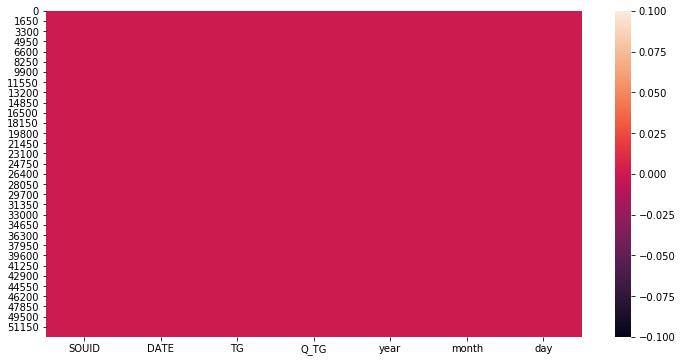

In [5]:
sns.heatmap(df.isna())
df.isna().sum()

In [6]:
df.set_index('DATE', inplace = True)

In [7]:
df['Celsius'] = df['TG'] * 0.1
df['Kelvin'] = df['Celsius'] + 273.15 

In [8]:
df['differences'] = df.Kelvin.diff()
df['pct_change'] = df.Kelvin.pct_change()

In [9]:
df.head()

,SOUID,TG,Q_TG,year,month,day,Celsius,Kelvin,differences,pct_change
DATE,,,,,,,,,,
1876-01-01,127488,22,0,1876,1,1,2.2,275.35,NaN,NaN
1876-01-02,127488,25,0,1876,1,2,2.5,275.65,0.3,0.001090
1876-01-03,127488,3,0,1876,1,3,0.3,273.45,-2.2,-0.007981
1876-01-04,127488,-58,0,1876,1,4,-5.8,267.35,-6.1,-0.022308
1876-01-05,127488,-98,0,1876,1,5,-9.8,263.35,-4.0,-0.014962


In [10]:
df['seasonal_mean'] = df['pct_change'].groupby(df['month']).transform('mean')
df['deseasonalized'] = df['pct_change'] - df['seasonal_mean']

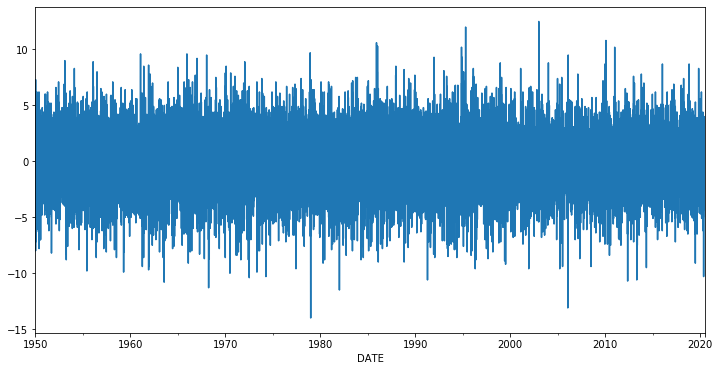

In [11]:
df.Celsius['1950':].diff().plot()

## Train-test split

In [12]:
df_clean = df['1950':]
df_train = df['1950':'2019']
df_test = df['2019':]

In [40]:
df_test['y_pred_mean'] = df_train['Kelvin'].mean()
df_test['y_pred_mean_pct_change'] = df_train['pct_change'].mean()
df_test['y_pred_mean_pct_change'] += 1
df_test['y_pred_mean_pct_change'] = np.cumprod(df_test['y_pred_mean_pct_change'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [47]:
df_train.groupby('month')['pct_change'].mean()

month
1     0.000019
2     0.000358
3     0.000593
4     0.000633
5     0.000447
6     0.000317
7     0.000245
8    -0.000304
9    -0.000529
10   -0.000580
11   -0.000503
12   -0.000238
Name: pct_change, dtype: float64

In [39]:
# Take the last actual observation as starting point
last_observation = df_train['Kelvin'][-1]

df_test['y_pred_mean_pct_change'] *= last_observation


df_test.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

ValueError: Length of values does not match length of index

In [35]:
# Define a function that plots the forecast for us
def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.Kelvin[-1000:].plot(label='Training Data')
    y_test.Kelvin[-1000:].plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    #plt.title('Nr. of Passengers per Month over Time', fontsize=15)
    #plt.ylabel('Nr. of Passengers', fontsize=12)
    #plt.xlabel('Date', fontsize=12)
    #plt.legend()
    # plt.savefig('mean_baseline.png')
    #plt.show()

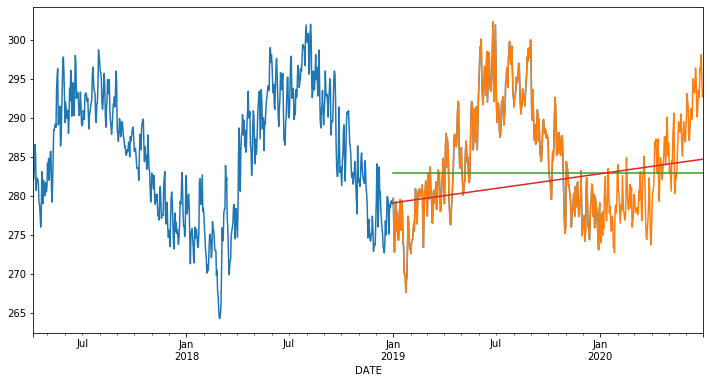

In [37]:
# Plot the forecast
plot_forecast(df_train, df_test, ['y_pred_mean', 'y_pred_mean_pct_change'])